In [1]:
import sys
sys.path.append("../src")

import numpy as np
from copy import deepcopy
import util
from other_methods import simulate, net
import basin
import itertools
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors


In [2]:
# Use cp (cupy or numpy)
CUPY, cp = util.import_cp_or_np(try_cupy=1)


# ============================================================
# Small helpers
# ============================================================
def map_idx(idx_full, ncols, assume_doubled=True):
    """Map G.nodeNums index -> column index of matrices with width ncols."""
    if idx_full is None or ncols <= 0:
        return None
    idx_full = int(idx_full)
    ncols = int(ncols)
    return (idx_full % ncols) if assume_doubled else (idx_full if idx_full < ncols else None)


def base_genes(G):
    """Only real genes (no '!X' shadow nodes)."""
    return [g for g in G.nodeNames if not g.startswith("!")]


def aligned_gene_indices(G_left, G_right, mat_left, mat_right, exclude_genes=(), assume_doubled=True):
    """
    Return (genes, idx_left, idx_right) where idx_* are in matrix column space.
    Excludes genes by NAME (exclude_genes).
    """
    exclude_genes = set(exclude_genes)

    nL = int(mat_left.shape[1])
    nR = int(mat_right.shape[1])

    genes = [g for g in base_genes(G_left) if (g in G_right.nodeNums) and (g not in exclude_genes)]

    idxL, idxR, common = [], [], []
    for g in genes:
        i = map_idx(G_left.nodeNums.get(g), nL, assume_doubled=assume_doubled)
        j = map_idx(G_right.nodeNums.get(g), nR, assume_doubled=assume_doubled)
        if i is None or j is None:
            continue
        common.append(g)
        idxL.append(i)
        idxR.append(j)

    return common, cp.asarray(idxL, dtype=cp.int32), cp.asarray(idxR, dtype=cp.int32)


def delta_aligned(mat_left, mat_right, idx_left, idx_right):
    """Compute |mat_left[:, idx_left] - mat_right[:, idx_right]| safely for numpy/cupy."""
    iL = cp.asnumpy(idx_left) if hasattr(cp, "asnumpy") else np.array(idx_left)
    iR = cp.asnumpy(idx_right) if hasattr(cp, "asnumpy") else np.array(idx_right)

    nL = int(mat_left.shape[1])
    nR = int(mat_right.shape[1])

    mask = (iL < nL) & (iR < nR)
    iL = iL[mask].astype(np.int64)
    iR = iR[mask].astype(np.int64)

    if iL.size == 0:
        raise RuntimeError("No aligned indices remain after filtering.")

    return cp.abs(mat_left[:, iL] - mat_right[:, iR])


def neo_sample_fraction_from_delta(delta, eps):
    """
    neo_fraction = fraction of samples that have >=1 changed gene (delta > eps).
    """
    changed = (delta > eps)
    return float(cp.mean(cp.any(changed, axis=1)))


def deleterious_count(x_fin, identity_markers, diversity_markers, G, eps=1e-3, assume_doubled=True):
    """Integer count of marker violations on x_fin."""
    ncols = int(x_fin.shape[1])
    IM_bad = 0
    DM_bad = 0

    for gene, req_val in identity_markers.items():
        idx = map_idx(G.nodeNums.get(gene), ncols, assume_doubled=assume_doubled)
        if idx is None:
            continue
        m = float(cp.mean(x_fin[:, idx]))
        if abs(m - req_val) > eps:
            IM_bad += 1

    for gene in diversity_markers:
        idx = map_idx(G.nodeNums.get(gene), ncols, assume_doubled=assume_doubled)
        if idx is None:
            continue
        m = float(cp.mean(x_fin[:, idx]))
        if m < eps or m > 1.0 - eps:
            DM_bad += 1

    return IM_bad + DM_bad


# ============================================================
# Main scan (simplified) - only exclude_nodes, no meta, no num_samples arg
# ============================================================
def scan_controllers(
    params_file,
    network_file,
    identity_markers,
    diversity_markers,
    max_order=1,
    exclude_nodes=("Y",),
    eps_change=1e-2,
    assume_doubled=True,
):
    """
    Returns:
      - orders
      - valid_controllers
      - neo_fractions
      - deleterious_counts

    Notes:
      - exclude_nodes is the ONLY exclusion knob (by gene NAME)
      - No meta returned
      - No num_samples arg here (use whatever is in params.yaml / sim defaults)
      - Keeps your current behavior: rebuilds G_free per controller
    """

    # ---- Load params ----
    params_base = util.load_yaml(params_file)
    params2 = deepcopy(params_base)
    params2["network_file"] = network_file
    params2["verbose_poke"] = False
    params2["use_mutations"] = True

    sim_params = simulate.get_sim_params(params2)
    params_global = {**sim_params, **params2}

    # ---- Candidate nodes ----
    G0 = net.Net(params_global)
    G0.prepare(params_global)

    exclude_nodes = set(exclude_nodes)
    candidates = [g for g in base_genes(G0) if g not in exclude_nodes]

    # ---- Outputs ----
    orders = []
    valid_controllers = []
    neo_fractions = []
    deleterious_counts = []

    # ---- Scan ----
    for k in range(1, max_order + 1):
        print(f"\n===== Checking order {k} controllers =====")

        for combo in itertools.combinations(candidates, k):
            for assignment in itertools.product([0, 1], repeat=k):

                controller = dict(zip(combo, assignment))

                # 1) mutated run
                params_test = deepcopy(params_global)
                params_test["mutations"] = controller
                params_test["use_mutations"] = True

                G_test = net.Net(params_test)
                G_test.prepare(params_test)

                avg, x_fin = simulate.measure(params_test, G_test)

                # validity: require Y == 1
                y_idx = map_idx(G_test.nodeNums.get("Y"), int(x_fin.shape[1]), assume_doubled=assume_doubled)
                if y_idx is None or not bool(cp.all(x_fin[:, y_idx] == 1)):
                    continue

                # deleterious count on mutated final states
                dcount = deleterious_count(
                    x_fin, identity_markers, diversity_markers, G_test,
                    eps=1e-3, assume_doubled=assume_doubled
                )

                # 2) free run from x_fin (NO caching, per your request)
                params_free = deepcopy(params_global)
                params_free["mutations"] = {}
                params_free["use_mutations"] = False

                G_free = net.Net(params_free)
                G_free.prepare(params_free)

                avg2, _ = simulate.measure(params_free, G_free, x0=x_fin)

                # 3) compute neo_fraction (sample-based), excluding exclude_nodes only
                genes, idx_test, idx_free = aligned_gene_indices(
                    G_test, G_free, avg, avg2,
                    exclude_genes=exclude_nodes,
                    assume_doubled=assume_doubled
                )
                if len(genes) == 0:
                    raise RuntimeError("No comparable genes remain for neo computation (after exclusions).")

                delta = delta_aligned(avg, avg2, idx_test, idx_free)
                neo_frac = neo_sample_fraction_from_delta(delta, eps=eps_change)

                # store
                orders.append(k)
                valid_controllers.append(controller)
                deleterious_counts.append(dcount)
                neo_fractions.append(neo_frac)

    return {
        "orders": orders,
        "valid_controllers": valid_controllers,
        "neo_fractions": neo_fractions,
        "deleterious_counts": deleterious_counts,
    }


In [3]:
def violin_plot_general(
    orders,
    neo_fractions,
    deleterious_fractions,   # in [0,1]
    code_fig,
    max_order=3,
    value_y="neo",
    color_by="deleterious"
    ):

    # Continuous colormap (green → yellow → red)
    cmap = cm.get_cmap("RdYlGn_r")   # reversed so green = low, red = high
    norm = mcolors.Normalize(vmin=0.0, vmax=1.0)

    # ---------------------- Data ----------------------
    metric = {
        "neo": np.array(neo_fractions, dtype=float),
        "deleterious": np.array(deleterious_fractions, dtype=float)
    }

    orders = np.array(orders)
    yvals_all = metric[value_y]
    colvals_all = metric[color_by]

    # ---------------------- Figure ----------------------
    fig, ax = plt.subplots(figsize=(10, 8))   # <-- NEW WIDTH × HEIGHT
    # Compressed spacing between categories
    spacing = 0.6
    xpos = {k: 1 + spacing*(k-1) for k in range(1, max_order+1)}

    # ---------------------- Precompute y-ticks ----------------------
    ymin = np.min(yvals_all) if len(yvals_all) > 0 else 0
    ymax = np.max(yvals_all) if len(yvals_all) > 0 else 1

    ytick_min = np.floor(ymin / 0.5) * 0.5
    ytick_max = np.ceil(ymax / 0.5) * 0.5

    # If range collapses, expand by 0.5
    if ytick_min == ytick_max:
        ytick_max += 0.5

    # ---------------------- Loop over orders ----------------------
    for k in range(1, max_order + 1):
        mask = (orders == k)
        vals_y = yvals_all[mask]
        vals_c = colvals_all[mask]
        xk = xpos[k]

        # =============================================================
        # CASE 1: NO valid controllers → show placeholder
        # =============================================================
        if len(vals_y) == 0:

            fake_vals = np.array([0, 0.0001])

            parts = ax.violinplot(
                [fake_vals],
                positions=[xk],
                showextrema=False
            )

            for pc in parts["bodies"]:
                pc.set_facecolor((0, 0, 0, 0))   # transparent
                pc.set_edgecolor("gray")
                pc.set_linewidth(1.0)

            ax.text(
                xk,
                (ytick_min + ytick_max) / 2,
                "no control",
                ha="center",
                fontsize=8,
                color="gray"
            )

            continue

        # =============================================================
        # CASE 2: Normal violin plotting
        # =============================================================
        mean_frac = float(np.mean(vals_c))
        color = cmap(norm(mean_frac))


        parts = ax.violinplot([vals_y], positions=[xk], showextrema=False)
        for pc in parts["bodies"]:
            pc.set_facecolor(color)
            pc.set_edgecolor("black")
            pc.set_alpha(0.9)

        vals_y = np.array(vals_y)

        # --- Jitter ---
        if np.std(vals_y) < 1e-6:
            x_j = np.random.normal(0, 0.04, size=len(vals_y))
            y_j = np.random.normal(0, 0.01, size=len(vals_y))
            plot_y = vals_y + y_j
        else:
            x_j = np.random.normal(0, 0.02, size=len(vals_y))
            plot_y = vals_y

        ax.scatter(
            xk + x_j,
            plot_y,
            s=14,
            color="black",
            alpha=0.55,
            zorder=1
        )

        # --- Percentile bars ---
        p10, q1, q3, p90 = np.percentile(vals_y, [10, 25, 75, 90])

        ax.plot([xk, xk], [p10, p90], color="black", lw=1.5)
        ax.plot([xk, xk], [q1, q3], color="black", lw=6)

        ax.scatter(
            xk,
            np.mean(vals_y),
            color="red",
            edgecolor="black",
            s=70,
            zorder=3
        )

    # ---------------------- Axis labels ----------------------
    label_map = {
        "neo": "Emergence of de novo attractor",
        "deleterious": "Deleterious effect"
    }

    ax.set_xticks([xpos[k] for k in range(1, max_order+1)])
    ax.set_xticklabels(range(1, max_order+1))

    ax.set_xlabel("Order of controller", fontsize=14)
    ax.set_ylabel(label_map[value_y], fontsize=14)

    # ax.set_yticks(np.arange(ytick_min, ytick_max + 0.001, 0.5))
    # ---------------------- Colorbar legend ----------------------
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    cbar = plt.colorbar(
        sm,
        ax=ax,
        fraction=0.045,
        pad=0.04
    )

    cbar.set_label(
        "% Fraction of De Novo Attractor Emergence",
        fontsize=12
    )

    # Percentage ticks
    ticks = np.linspace(0, 1, 6)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{int(t*100)}%" for t in ticks])

    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.savefig(f"{code_fig}_violin_plot.png", dpi=600, bbox_inches="tight")
    plt.savefig(f"{code_fig}_violin_plot.svg", bbox_inches="tight")
    plt.show()


# Figure 4

## CPC_IPSC to Cardiomyocte Example

In [5]:
#iPSC - Carciomyocyte
identity_markers_cpc = {
        "MESP1": 0,
        "Ripply": 1,
        "CM": 1,
        "CP": 1,
    }
diversity_markers_cpc = []

out = scan_controllers(
    params_file="../input/params.yaml",
    network_file="../input/networks/mainExamples/cpc_ipsc.bnet",
    identity_markers=identity_markers_cpc,
    diversity_markers=diversity_markers_cpc,
    max_order=3,
    eps_change=0.01,
    exclude_nodes=("Y")
)


===== Checking order 1 controllers =====

===== Checking order 2 controllers =====

===== Checking order 3 controllers =====


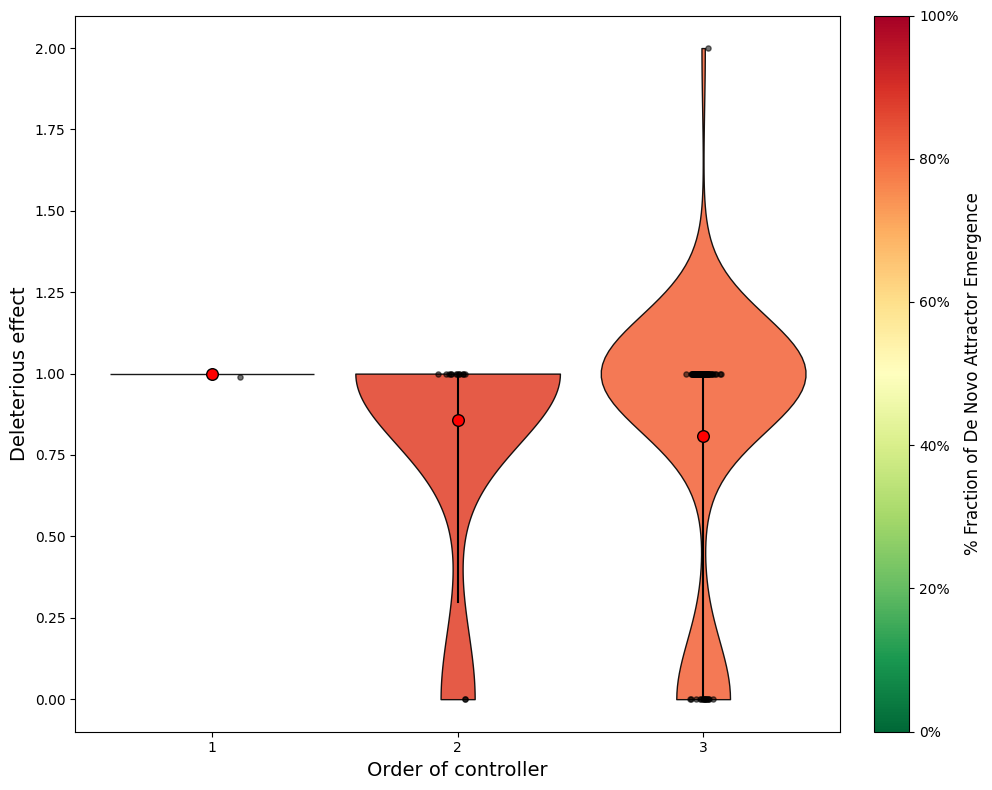

In [6]:
n_markers = len(identity_markers_cpc) + len(diversity_markers_cpc)

if n_markers == 0:
    deleterious_fractions = np.zeros(len(out["deleterious_counts"]))
else:
    deleterious_fractions = np.array(out["deleterious_counts"])
    
violin_plot_general(
    out["orders"],
    out["neo_fractions"],
    deleterious_fractions,
    code_fig="cpc_ipsc",
    value_y="deleterious",
    color_by="neo"
)

# Figure 5

## GMP to Mast Cell Example

In [7]:
#CPC IPSC
identity_markers_gmp3 = {
    "cebpa": 0,
    "mitf": 1,
    "mmcp6": 1,
    "mccpa": 1,
    "ckit": 1
}

diversity_markers_gmp3 = ["gata1", "egr2", "pu1", "runx1", "cmyb", "scl", "gmcsfr", "fceRIb", "fceRIa"]


results_gmp3 = scan_controllers(
    params_file="../input/params.yaml",
    network_file="../input/networks/mainExamples/ramirez_gmp.bnet",
    identity_markers = identity_markers_gmp3,
    diversity_markers= diversity_markers_gmp3,
    max_order=3,
    eps_change=0.01,
    exclude_nodes=["Y", "ckit"]
)


===== Checking order 1 controllers =====

===== Checking order 2 controllers =====

===== Checking order 3 controllers =====


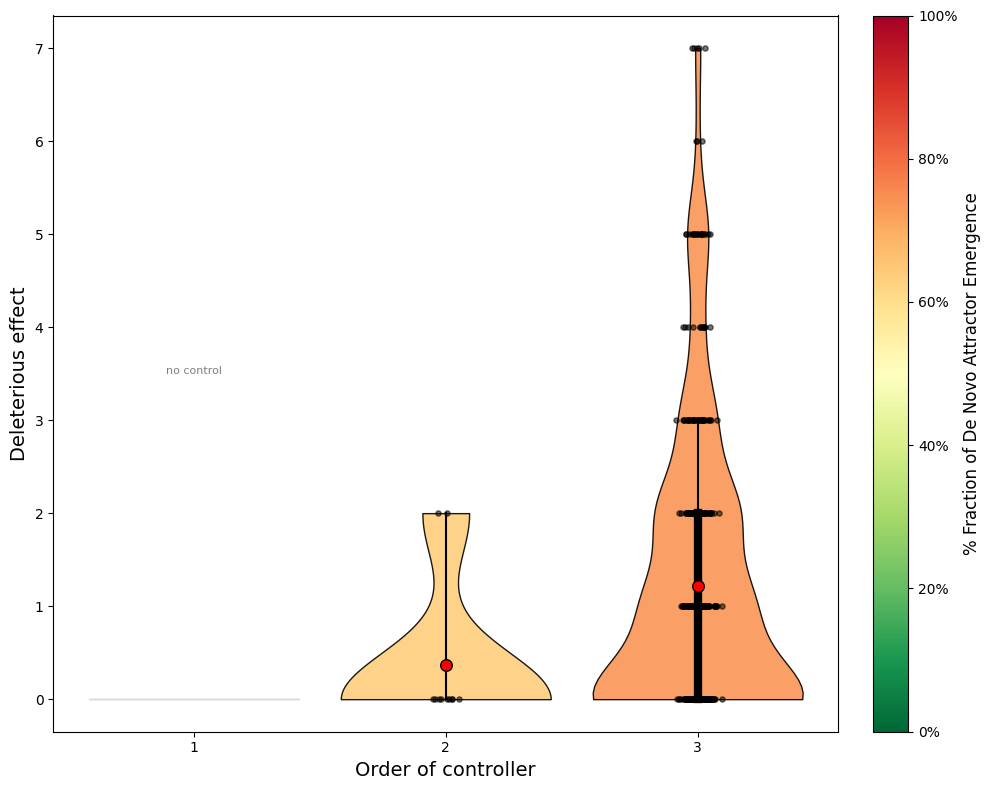

In [8]:
n_markers = len(identity_markers_gmp3) + len(diversity_markers_gmp3)

if n_markers == 0:
    deleterious_fractions = np.zeros(len(results_gmp3["deleterious_counts"]))
else:
    deleterious_fractions = np.array(results_gmp3["deleterious_counts"])
    
violin_plot_general(
    results_gmp3["orders"],
    results_gmp3["neo_fractions"],
    deleterious_fractions,
    code_fig="gmp",
    value_y="deleterious",
    color_by="neo"
)

# Figure 6

## Anti-inflammatory Macrophage Example

In [9]:
#CPC IPSC
identity_markers_M2 = {
    "STAT1": 0,
    "STAT5": 0,
    "NF_kB": 0,
    "IL12_out": 0
}

diversity_markers_M2 = ["PPARg", "STAT6", "JMJD3", "ERK", "STAT3"]


results_M2 = scan_controllers(
    params_file="../input/params.yaml",
    network_file="../input/networks/mainExamples/macrophage.bnet",
    identity_markers=identity_markers_M2,
    diversity_markers=diversity_markers_M2,
    max_order=3,
    eps_change=0.01,
    exclude_nodes=["Y", "IL10_out"]
)


===== Checking order 1 controllers =====

===== Checking order 2 controllers =====

===== Checking order 3 controllers =====


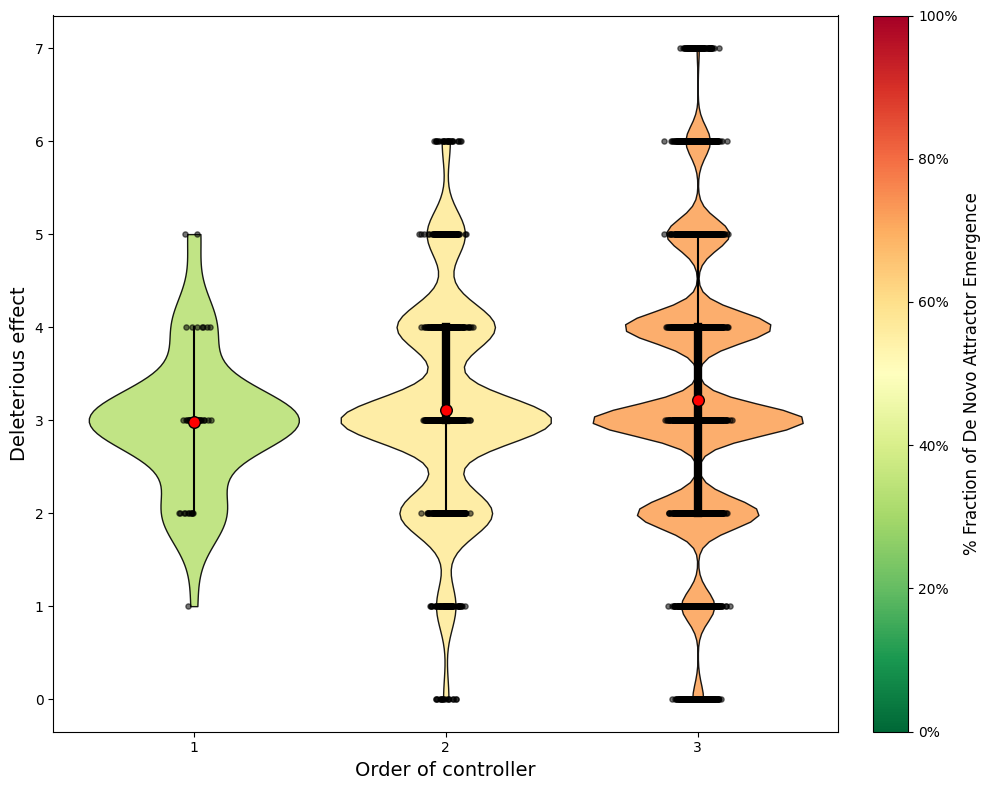

In [10]:
n_markers = len(identity_markers_M2) + len(diversity_markers_M2)

if n_markers == 0:
    deleterious_fractions = np.zeros(len(results_M2["deleterious_counts"]))
else:
    deleterious_fractions = np.array(results_M2["deleterious_counts"])
    
violin_plot_general(
    results_M2["orders"],
    results_M2["neo_fractions"],
    deleterious_fractions,
    code_fig="macrophage",
    value_y="deleterious",
    color_by="neo"
)